# **Reprise de l'exemple fourni** : Sentence Embedding

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (`model_type`) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle `'cardiffnlp/twitter-roberta-base-sentiment'` surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (`max_length`)
    * Le `batch_size`
    * La perplexité du Tsne (`perplexity` à 30 par défaut)

# Chargement des données

(14640, 14)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
Tweets,,,,,,
tweet_id,14640,14485,0,1.000000,0.989413,int64
airline_sentiment,14640,3,0,1.000000,0.000205,object
airline_sentiment_confidence,14640,1023,0,1.000000,0.069877,float64
negativereason,9178,10,5462,0.626913,0.001090,object
negativereason_confidence,10522,1410,4118,0.718716,0.134005,float64
airline,14640,6,0,1.000000,0.000410,object
airline_sentiment_gold,40,3,14600,0.002732,0.075000,object
name,14640,7701,0,1.000000,0.526025,object
negativereason_gold,32,13,14608,0.002186,0.406250,object


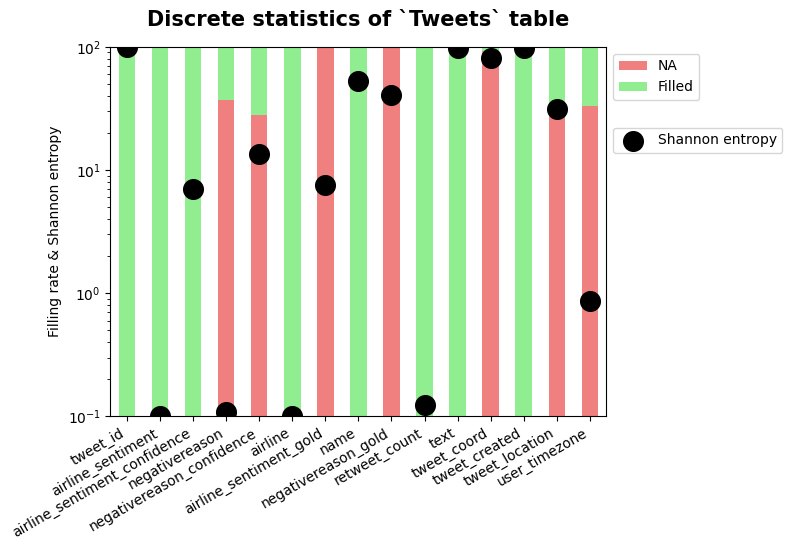

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
569247724496822272,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,TheWaynePyle,NaN,0,@SouthwestAir has the absolute worst customer ...,NaN,2015-02-21 13:30:08 -0800,California,Pacific Time (US & Canada)
568136806224379904,positive,1.0000,NaN,NaN,Southwest,NaN,eliinthemiddle,NaN,1,@SouthwestAir JUST GAVE ME TICKETS TO SEE @Ima...,NaN,2015-02-18 11:55:44 -0800,NaN,Mountain Time (US & Canada)
569942011916259330,negative,0.6326,Customer Service Issue,0.6326,American,NaN,remixrio,NaN,0,@AmericanAir really appreciate the great custo...,NaN,2015-02-23 11:28:59 -0800,Brooklyn,Pacific Time (US & Canada)


In [1]:
from tx_ml import load
from pepper_utils import show_discrete_stats
raw_tweets = load("Tweets.csv")
print(raw_tweets.shape)
show_discrete_stats(raw_tweets.reset_index(), "Tweets")
display(raw_tweets.sample(3))

## Extrait du corpus

In [20]:
from flipkart_utils import full_show_sample
corpus = raw_tweets.text
display(corpus.shape)
full_show_sample(corpus, print_func=print)

(10445,)

(568587181264146432, "@united 3 Gate changes in 30 minutes for flight to Roanoke and flight to sous falls in O'hare... Painful")
(569384007550394369, '@SouthwestAir I use to #LUV swa but after an hour and counting on hold, for a flight they Cancelled Flighted on me? #noluv')
(569491590105980929, '@USAirways Many thanks for your reply! http://t.co/6CGFv02gzb')
(569992362728005632, 'Great management of @USAirways twitter account. Thank you.')
(570213783085432832, '@USAirways Youre batting .1000. Every flight Ive taken is delayed. Worst airline. ever.')


## Division en phrases

In [21]:
from tx_prep import ravel_corpus_sents
corpus_sents = ravel_corpus_sents(corpus)
display(corpus_sents)

,id,sent_id,text
0,570306133677760513,0,@VirginAmerica What @dhepburn said.
1,570301031407624196,0,@VirginAmerica it's really aggressive to blast...
2,570300817074462722,0,@VirginAmerica and it's a really big bad thing...
3,570300767074181121,0,@VirginAmerica seriously would pay $30 a fligh...
4,570300767074181121,1,it's really the only bad thing about flying VA
...,...,...,...
21517,569587371693355008,2,That's called shitty customer svc
21518,569587242672398336,0,@AmericanAir Please bring American Airlines to...
21519,569587188687634433,0,"@AmericanAir you have my money, you change my ..."
21520,569587188687634433,1,Any other suggestions so I can make my commitm...


## Filtrage sur un niveau de confiance maximal du sentiment

In [2]:
raw_tweets.airline_sentiment_confidence.value_counts(normalize=True)

1.0000    0.713456
0.6667    0.004850
0.6632    0.002391
0.6596    0.002049
0.6559    0.002049
            ...   
0.3674    0.000068
0.6155    0.000068
0.3708    0.000068
0.6905    0.000068
0.3487    0.000068
Name: airline_sentiment_confidence, Length: 1023, dtype: float64

## Distribution par classe (de sentiment)

In [3]:
# Filtre de tweets avec un niveau de confiance à 1 sur le sentiment
import pandas as pd
raw_tweets = raw_tweets[raw_tweets.airline_sentiment_confidence == 1]
print(raw_tweets.shape)
vc = pd.concat([
    raw_tweets.airline_sentiment.value_counts().rename('#'),
    raw_tweets.airline_sentiment.value_counts(normalize=True).rename('%')
], axis=1)
display(vc)

(10445, 14)


,#,%
negative,7382,0.706750
neutral,1548,0.148205
positive,1515,0.145045


# Echantillonnage (stratifié)

Ehantillon de 3000 tweets, associés à un sentiment pour moitié positif, pour moitié négatif.

Dans la version originale de l'exemple, la sélection des 1500 premiers positifs et 1500 premiers négatifs fait superformer les ARI.

La version revisitée ici réalise un échantillonage aléatoire de ces 1500 + 1500 tweets, ce qui produit des résultats un peu moins avantageux, notamment dans les modélisations classiques à base de sacs de mots.

In [32]:
from tx_ml import tweets_3k_sample
rt_3k_sample = tweets_3k_sample(raw_tweets)
compl = raw_tweets.loc[raw_tweets.index.difference(rt_3k_sample.index)]
display(compl.shape)

(3000, 14)

(7422, 14)

# Nettoyage du texte

Version intégrée dans une fonction qui étend `rt_3k_sample` et version *sous le capot*.

## Tout en un

In [5]:
from tx_ml import preprocess, save_as
preprocess(rt_3k_sample)
display(rt_3k_sample[rt_3k_sample.columns[-3:]].head(3))
save_as(rt_3k_sample, '3k_sample_clean.csv')

,sent_bow,sent_bow_lem,sent_deep_learn
tweet_id,,,
568505037833396224,usairways keep missing updated connections nee...,usairways keep missing updated connection need...,usairways i keep missing my updated connection...
570107683027718144,united cancelled flightn left fend flt came la...,united cancelled flightn left fend flt came la...,united no cancelled flightn just left us to fe...
569360777926217728,southwestair got new record hrs air hrs waitin...,southwestair got new record hr air hr waiting ...,southwestair that 's got ta be a new record : ...


## Décomposition

In [6]:
from tx_prep import apply_functions
import pandas as pd
from tx_ml import (
    prepare_text_for_bow,
    prepare_text_for_bow_with_lemmatization,
    prepare_text_for_deep_learning
)
functions = [
    prepare_text_for_bow,
    prepare_text_for_bow_with_lemmatization,
    prepare_text_for_deep_learning
]
result_names = ['sent_bow', 'sent_bow_lem', 'sent_deep_learn']
res = pd.concat(apply_functions(rt_3k_sample.text, functions, result_names), axis=1)
display(res.head(3))

,sent_bow,sent_bow_lem,sent_deep_learn
tweet_id,,,
568505037833396224,usairways keep missing updated connections nee...,usairways keep missing updated connection need...,usairways i keep missing my updated connection...
570107683027718144,united cancelled flightn left fend flt came la...,united cancelled flightn left fend flt came la...,united no cancelled flightn just left us to fe...
569360777926217728,southwestair got new record hrs air hrs waitin...,southwestair got new record hr air hr waiting ...,southwestair that 's got ta be a new record : ...


## Les divers prétraitements

### Casefolding

C'est la première opération normalisante à effectuer.

In [22]:
from tx_ml import load
from tx_prep import ravel_corpus_sents, corpus_casefold
corpus = load('Tweets.csv').text
corpus_sents = ravel_corpus_sents(corpus)
sents = corpus_sents[corpus_sents.columns[-1]]
sents = corpus_casefold(sents)
display(sents)

0                      @virginamerica what @dhepburn said.
1        @virginamerica plus you've added commercials t...
2        @virginamerica i didn't today... must mean i n...
3        @virginamerica it's really aggressive to blast...
4        @virginamerica and it's a really big bad thing...
                               ...                        
29378    @americanair you have my money, you change my ...
29379    any other suggestions so i can make my commitm...
29380                                                    ?
29381    @americanair we have 8 ppl so we need 2 know h...
29382    plz put us on standby for 4 people on the next...
Name: text, Length: 29383, dtype: object

### Remplacement (ou élimination) de certains symboles

In [23]:
from tx_ml import load
from tx_prep import ravel_corpus_sents, corpus_casefold, corpus_replace_symbols
corpus = load('Tweets.csv').text
corpus_sents = ravel_corpus_sents(corpus)
sents = corpus_sents[corpus_sents.columns[-1]]
sents = corpus_casefold(sents)
sents = corpus_replace_symbols(sents, "+-/#@", " ")
display(sents)

0                        virginamerica what dhepburn said 
1         virginamerica plus you've added commercials t...
2         virginamerica i didn't today must mean i need...
3         virginamerica it's really aggressive to blast...
4         virginamerica and it's a really big bad thing...
                               ...                        
29378     americanair you have my money you change my f...
29379    any other suggestions so i can make my commitm...
29380                                                    ?
29381     americanair we have 8 ppl so we need 2 know h...
29382    plz put us on standby for 4 people on the next...
Name: text, Length: 29383, dtype: object

### Décomposition des phrases en listes de mots

In [24]:
from tx_ml import load
from tx_prep import ravel_corpus_sents, corpus_casefold, word_tokenize_corpus
corpus_sents = ravel_corpus_sents(load('Tweets.csv').text)
sents = corpus_sents[corpus_sents.columns[-1]]
sents = corpus_casefold(sents)
sents = corpus_replace_symbols(sents, "+-/#@", " ")
tokenized_sents = word_tokenize_corpus(sents)
display(tokenized_sents)

0                    [virginamerica, what, dhepburn, said]
1        [virginamerica, plus, you, 've, added, commerc...
2        [virginamerica, i, did, n't, today, must, mean...
3        [virginamerica, it, 's, really, aggressive, to...
4        [virginamerica, and, it, 's, a, really, big, b...
                               ...                        
29378    [americanair, you, have, my, money, you, chang...
29379    [any, other, suggestions, so, i, can, make, my...
29380                                                  [?]
29381    [americanair, we, have, 8, ppl, so, we, need, ...
29382    [plz, put, us, on, standby, for, 4, people, on...
Name: text, Length: 29383, dtype: object

### Filtrage des mots sans intérêt

Stopwords, ponctuation, mots en dehors d'un intervalle de taille, mots contenant un pattern particulier.

In [25]:
from tx_ml import load
from tx_prep import ravel_corpus_sents, corpus_casefold, word_tokenize_corpus, filter_tweets
corpus_sents = ravel_corpus_sents(load('Tweets.csv').text)
sents = corpus_sents[corpus_sents.columns[-1]]
sents = corpus_casefold(sents)
sents = corpus_replace_symbols(sents, "+-/#@", " ")
tokenized_sents = word_tokenize_corpus(sents)
filtered_tokenized_sents = tokenized_sents.apply(filter_tweets)
display(filtered_tokenized_sents)

0                          [virginamerica, dhepburn, said]
1        [virginamerica, plus, added, commercials, expe...
2        [virginamerica, today, must, mean, need, take,...
3        [virginamerica, really, aggressive, blast, obn...
4                 [virginamerica, really, big, bad, thing]
                               ...                        
29378    [americanair, money, change, flight, answer, p...
29379                      [suggestions, make, commitment]
29380                                                   []
29381    [americanair, ppl, need, know, many, seats, ne...
29382            [plz, put, standby, people, next, flight]
Name: text, Length: 29383, dtype: object

### Lemmatisation

Abstraction du mot en le remplaçant par son représentant de lexème.

C'est la dernière étape (nous n'abordons pas l'analyse sémantique) avant de reformer les phrases comme chaînes.

In [26]:
from tx_ml import load
from tx_prep import (
    ravel_corpus_sents,
    corpus_casefold,
    corpus_replace_symbols,
    word_tokenize_corpus,
    filter_tweets,
    lemmatize_words
)
corpus_sents = ravel_corpus_sents(load('Tweets.csv').text)
sents = corpus_sents[corpus_sents.columns[-1]]
sents = corpus_casefold(sents)
sents = corpus_replace_symbols(sents, "+-/#@", " ")
sents = word_tokenize_corpus(sents)
sents = sents.apply(filter_tweets)
sents = sents.apply(lemmatize_words)
display(sents)

0                          [virginamerica, dhepburn, said]
1        [virginamerica, plus, added, commercial, exper...
2        [virginamerica, today, must, mean, need, take,...
3        [virginamerica, really, aggressive, blast, obn...
4                 [virginamerica, really, big, bad, thing]
                               ...                        
29378    [americanair, money, change, flight, answer, p...
29379                       [suggestion, make, commitment]
29380                                                   []
29381    [americanair, ppl, need, know, many, seat, nex...
29382            [plz, put, standby, people, next, flight]
Name: text, Length: 29383, dtype: object

### Tout en un, avec `join` final

In [28]:
from tx_ml import load
from tx_prep import preprocess_corpus, filter_tweets
sents, sents_index = preprocess_corpus(
    corpus=load('Tweets.csv').text,
    discard_symbols="+-/#@",
    discard_words_function=filter_tweets,
    # sent_tokenize=True,  # Tokenize sentences and return a sents_index
)
display(sents)
display(sents_index)

tweet_id
570306133677760513                          virginamerica dhepburn said
570301130888122368    virginamerica plus added commercial experience...
570301083672813571    virginamerica today must mean need take anothe...
570301031407624196    virginamerica really aggressive blast obnoxiou...
570300817074462722                   virginamerica really big bad thing
                                            ...                        
569587686496825344       americanair thank got different flight chicago
569587371693355008    americanair leaving minute late flight warning...
569587242672398336    americanair please bring american airline blac...
569587188687634433    americanair money change flight answer phone s...
569587140490866689    americanair ppl need know many seat next fligh...
Name: text, Length: 14640, dtype: object

None

# Initialisation commune aux différents modèles

Rechargement des données échantillonnées et prétraitées, analyse fréquentielle sommaire.

In [7]:
from tx_ml import load
tweets = load('3k_sample_clean.csv')
print(tweets.shape)

(3000, 17)


In [33]:
from tx_ml import encode_cats
cla_labels, cla_names = encode_cats(tweets.airline_sentiment)
print(cla_names, len(cla_names))
display(cla_labels.value_counts())

Index(['negative', 'positive'], dtype='object') 2


0    1500
1    1500
dtype: int64

In [11]:
display(tweets.sent_bow)

tweet_id
568505037833396224    usairways keep missing updated connections nee...
570107683027718144    united cancelled flightn left fend flt came la...
569360777926217728    southwestair got new record hrs air hrs waitin...
569506563628642304      southwestair let oversold earlybirdmeansnothing
569623211324735488       usairways really good deferring responsibility
                                            ...                        
570092184948645889                      americanair found footage happy
570224421194964992    americanair thank always start vacations t.co ...
569907141596864514                                         united thank
569527205291802624    usairways mellani whole team columbia absolute...
569949946146742272      americanair got new reservation tomorrow thanks
Name: sent_bow, Length: 3000, dtype: object

Corpus: SENT_BOW
n_sentences: 3000


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
freq,2,91,105,134,158,154,168,208,212,209,263,310,268,268,201,136,74,20,16,3


mean: 10.20
med : 11.00
std : 4.06


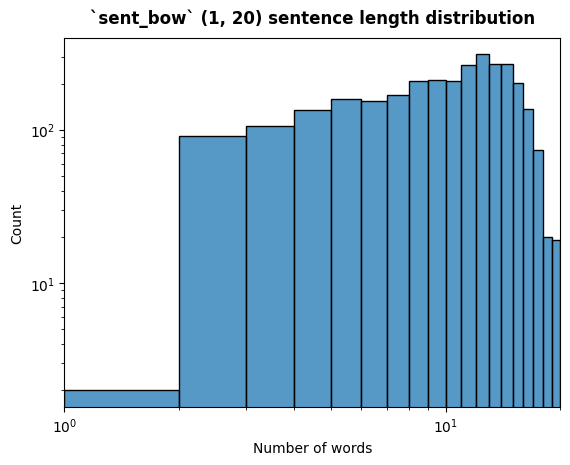

Corpus: SENT_DEEP_LEARN
n_sentences: 3000


,2,3,4,5,6,7,8,9,10,11,...,29,30,31,32,33,34,35,36,37,38
freq,7,31,43,47,66,80,58,69,84,63,...,116,98,63,38,35,18,10,5,3,3


mean: 19.88
med : 21.00
std : 7.91


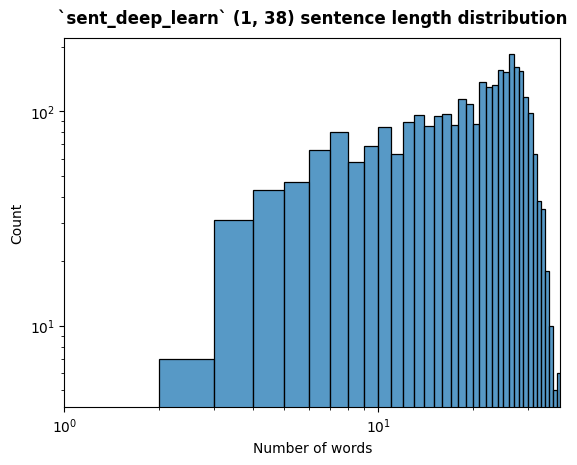

In [15]:
from tx_prep import word_tokenize_corpus, lens, display_lens_dist, show_lens_dist

def show_sent_lens(sents):
    print("Corpus:", sents.name.upper())
    print("n_sentences:", len(sents))
    tok_sents = word_tokenize_corpus(sents)
    sent_lens = lens(tok_sents)
    display_lens_dist(sent_lens)
    show_lens_dist(sent_lens, unit='word', log_scale=(True, True))

show_sent_lens(tweets.sent_bow)
show_sent_lens(tweets.sent_deep_learn)

# Bag of word - Tf-idf

## Vectorisation des phrases

In [38]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sents = tweets.sent_bow

c_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
f_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

c_sents = c_vectorizer.fit_transform(sents)
f_sents = f_vectorizer.fit_transform(sents)

display(sents.shape)
display(c_sents.shape)
display(f_sents.shape)

(3000,)

(3000, 5343)

(3000, 5343)

In [16]:
# depr version

# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

c_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
f_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

sent_bow_lem = tweets.sent_bow_lem
c_sent_bow_lem = c_vectorizer.fit_transform(sent_bow_lem)
f_sent_bow_lem = f_vectorizer.fit_transform(sent_bow_lem)

Sparsity index: 0.17


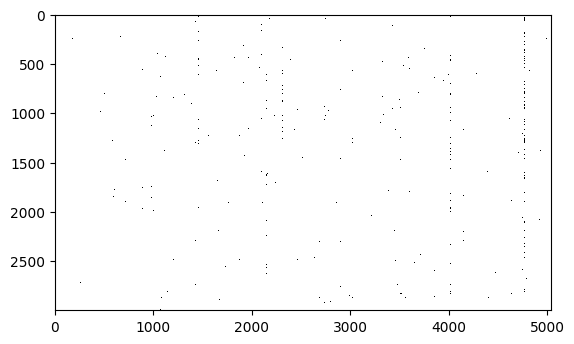

Sparsity index: 0.17


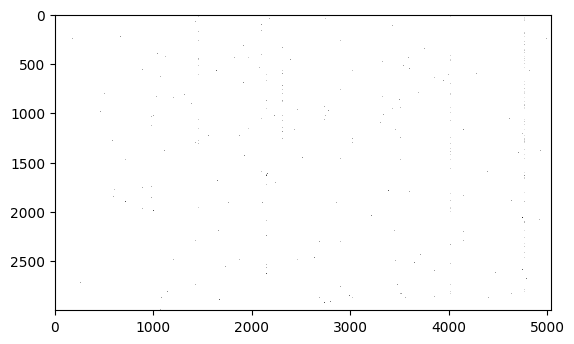

In [30]:
from tx_ml import show_sparsity
show_sparsity(c_sent_bow_lem)
show_sparsity(f_sent_bow_lem)

## Exécution des modèles

In [46]:
from pepper_utils import print_subtitle
from tx_ml import tsne_kmeans_ari
print_subtitle("CountVectorizer")
tsne_params = {"n_iter": 2000, "learning_rate": 200}
c_X_tsne, c_clu_labels, c_ari, _, _ = tsne_kmeans_ari(
    c_sents, cla_labels, verbosity=2, tsne_params=tsne_params
)
print_subtitle("TfidfVectorizer")
f_X_tsne, f_clu_labels, f_ari, _, _ = tsne_kmeans_ari(
    f_sents, cla_labels, verbosity=2, tsne_params=tsne_params
)


CountVectorizer
T-SNE time: 36.04s
KMeans time: 0.19s
ARI time: 0.00s
Total time : 36.23s

ARI : 0.0889

TfidfVectorizer
T-SNE time: 37.33s
KMeans time: 0.64s
ARI time: 0.00s
Total time : 37.97s

ARI : 0.1371


In [41]:
from pepper_utils import print_subtitle
from tx_ml import tsne_kmeans_ari
print_subtitle("CountVectorizer")
c_X_tsne, c_clu_labels, c_ari, _, _ = tsne_kmeans_ari(c_sents, cla_labels, verbosity=2)
print_subtitle("TfidfVectorizer")
f_X_tsne, f_clu_labels, f_ari, _, _ = tsne_kmeans_ari(f_sents, cla_labels, verbosity=2)


CountVectorizer
T-SNE time: 21.97s
KMeans time: 0.23s
ARI time: 0.00s
Total time : 22.20s

ARI : 0.0060

TfidfVectorizer
T-SNE time: 16.02s
KMeans time: 0.33s
ARI time: 0.00s
Total time : 16.36s

ARI : 0.4171


## Graphiques

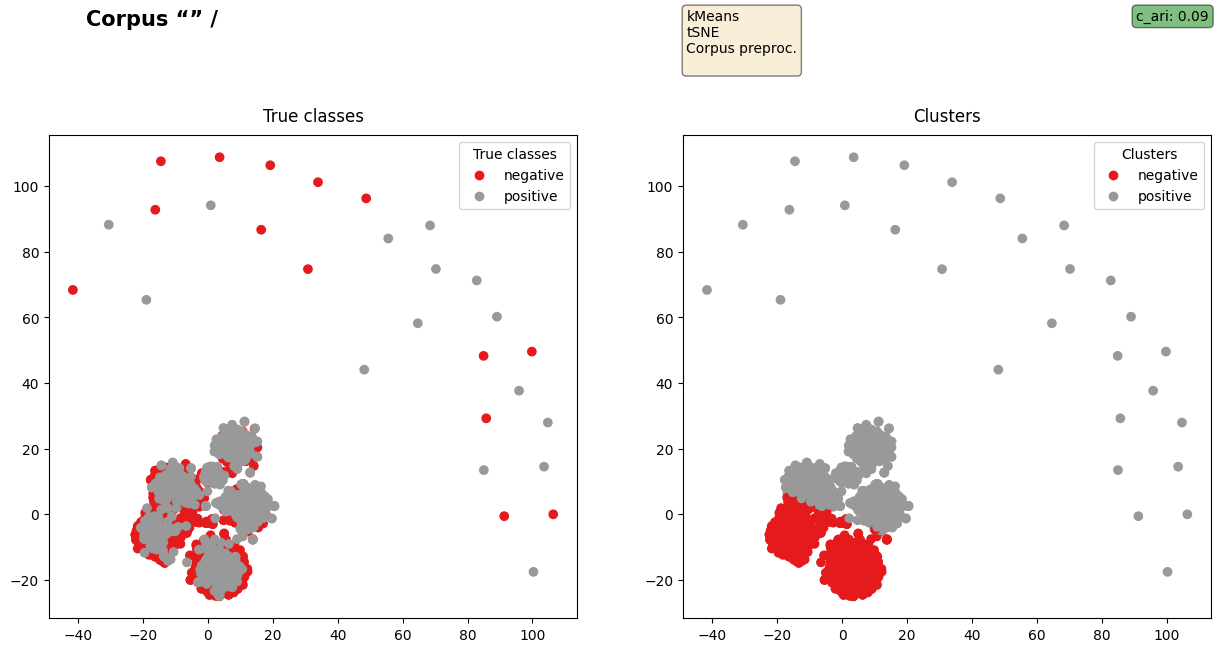

In [47]:
from tx_ml import show_tsne
show_tsne(
    cla_labels, cla_names,
    c_X_tsne, c_clu_labels,
    {"c_ari": round(c_ari, 2)}
)

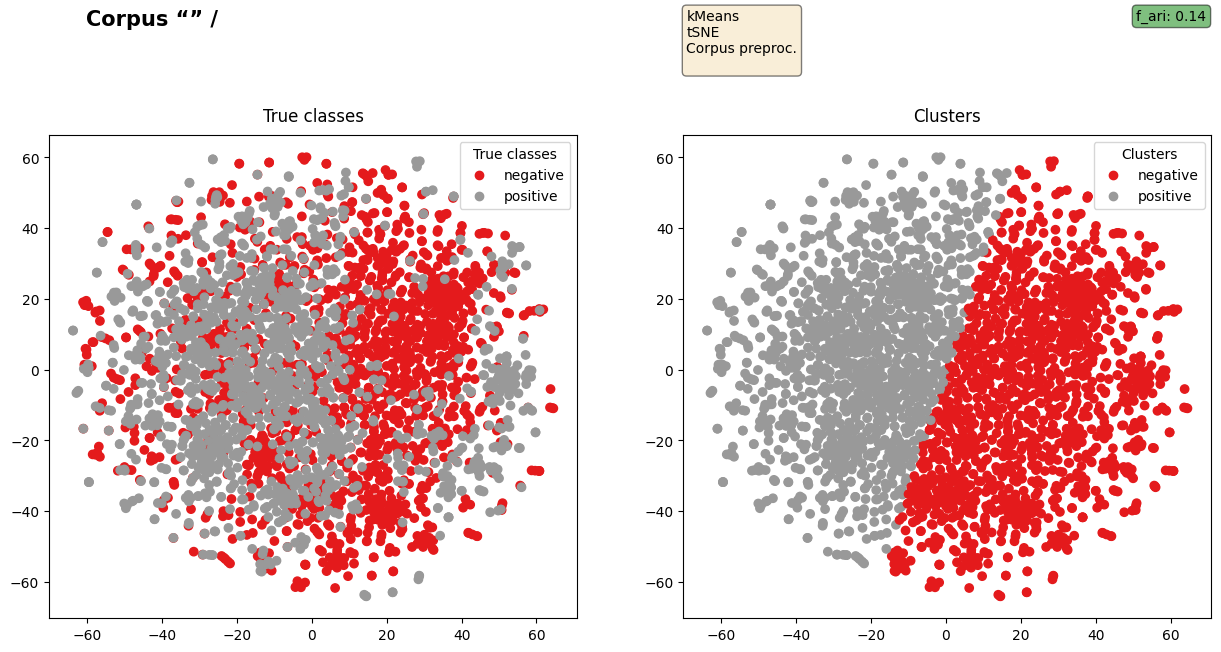

In [48]:
from tx_ml import show_tsne
show_tsne(cla_labels, cla_names, f_X_tsne, f_clu_labels, {"f_ari": round(f_ari, 2)})

# Word2Vec

ARI : 0.3

Les deux fonctions suivantes concernent la construction d'un modèle d'embedding en utilisant le modèle Word2Vec et le tokenizer Keras. La première fonction `get_embedding_matrix` sert à créer la matrice d'embedding en utilisant le modèle Word2Vec et le tokenizer Keras. Le but est de convertir chaque mot en vecteur à partir du modèle Word2Vec, et de stocker ces vecteurs dans une matrice. La matrice aura la forme `(vocab_size, w2v_size)`, où `vocab_size` est la taille du vocabulaire du tokenizer Keras et `w2v_size` est la dimension du modèle Word2Vec.

La seconde fonction `get_embeddeding_model` sert à construire un modèle Keras qui prend en entrée des phrases tokenizées et renvoie les vecteurs d'embedding associés. Elle crée un modèle Keras avec une entrée de forme `(nombre de phrases, longueur maximale de la phrase)` et renvoie un vecteur d'embedding de longueur `w2v_size` pour chaque phrase. Les poids pré-entraînés de la matrice d'embedding sont attachés à la couche d'embedding du modèle.

## Création du modèle Word2Vec

In [45]:
from tx_ml import load
tweets = load('3k_sample_clean.csv')
sent_bow_lem = tweets.sent_bow_lem
display(sent_bow_lem)

tweet_id
569696663742365696    jetblue lack made rough literally picked y'all...
569595745126494208                         usairways absolute crap week
568994755268513793    usairways can tell waited min charged phone ch...
568606238428270594    usairways ruined honeymoon causing miss intern...
569677563334942720    americanair 've never witnessed covert tactic ...
                                            ...                        
568118452965085184    united blown away stellar custserv thank t.co ...
567762099708112897                      southwestair finally got thanks
569861240375386112                                    united cool thank
567829387485130752                          southwestair awesome thanks
568837615220166657                          united thanks timely update
Name: sent_bow_lem, Length: 3000, dtype: object

Globals

In [46]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 24 # adapt to length of sentences

List of lists of Gesim preprocessed words

In [47]:
from tx_ml import gesim_simple_preprocess
sents = gesim_simple_preprocess(sent_bow_lem)
print(sents[:5])

[['jetblue', 'lack', 'made', 'rough', 'literally', 'picked', 'all', 'competitor'], ['usairways', 'absolute', 'crap', 'week'], ['usairways', 'can', 'tell', 'waited', 'min', 'charged', 'phone', 'change', 'fee', 'even', 'tho', 'allow', 'make', 'change', 'online'], ['usairways', 'ruined', 'honeymoon', 'causing', 'miss', 'international', 'flight', 'stranded'], ['americanair', 've', 'never', 'witnessed', 'covert', 'tactic', 'airline']]


In [48]:
from tx_ml import fit_word2vec
w2v_model = fit_word2vec(sents)

Build & train Word2Vec model ...
Vocabulary size: 4764
Word2Vec trained


In [49]:
model_vectors = w2v_model.wv
print(f"model_vectors ({len(model_vectors)}", model_vectors)
w2v_words = model_vectors.index_to_key
print(f"w2v_words ({len(w2v_words)})", w2v_words[:10])
print("flight vector", model_vectors['flight'][:50])

model_vectors (4764 KeyedVectors<vector_size=300, 4764 keys>
w2v_words (4764) ['flight', 'united', 'usairways', 'americanair', 'southwestair', 'jetblue', 'thanks', 'thank', 'service', 'customer']
flight vector [-0.75987375  0.81286925  0.60816866  0.29942456  0.27162418  0.76609445
 -0.3099404   0.03309206  0.33791256 -0.30948144 -0.06557262  1.1757935
 -0.8097618   0.3580973   0.14644931  0.6339237  -0.0849437  -0.54409164
  0.7803748  -0.02323828 -0.20948328  0.26777214 -0.05108099 -0.18427709
  0.6315871   0.27941087  0.30762112  0.34024334  0.13485123 -0.1265639
 -0.3746064   0.03651717  0.01044512  0.2026021   0.49683127  0.23758751
  0.70412314  1.1532007  -0.21338649 -0.11818527  0.14052904  0.83887655
  0.2866951  -0.27354237 -0.47351205  0.56655186  0.12744795  0.76586217
 -0.28880027  0.2212208 ]


In [50]:
from tx_ml import fit_keras_tokenizer
keras_tokenizer, x_sents = fit_keras_tokenizer(sents)
display(keras_tokenizer)
print(x_sents.shape)
display(x_sents)

Fit Tokenizer ...
Number of unique words: 4765


(3000, 24)


array([[   6,  333,   54, ...,    0,    0,    0],
       [   3,  411, 1114, ...,    0,    0,    0],
       [   3,  243,  180, ...,    0,    0,    0],
       ...,
       [   2,  253,    8, ...,    0,    0,    0],
       [   5,   47,    7, ...,    0,    0,    0],
       [   2,    7,  792, ...,    0,    0,    0]])

## Création de la matrice d'embedding

In [51]:
from tx_ml import get_embedding_matrix
embedding_matrix = get_embedding_matrix(w2v_model, keras_tokenizer)

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix:  (4765, 300)


## Création du modèle d'embedding

In [52]:
from tx_ml import get_embedding_model
keras_model = get_embedding_model(x_sents, w2v_model, keras_tokenizer, embedding_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1429500   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,429,500
Trainable params: 1,429,500
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [53]:
embeddings = keras_model.predict(x_sents)
embeddings.shape

94/94 [==============================] - 0s 2ms/step


(3000, 300)

In [54]:
from tx_ml import tsne_kmeans_ari
wve_X_tsne, wve_clu_labels, wve_ari = tsne_kmeans_ari(embeddings, cat_codes, cat_labels)

T-SNE time: 31.47s
KMeans time: 0.27s
ARI time: 0.00s
Total time : 31.74s

ARI : 0.3526


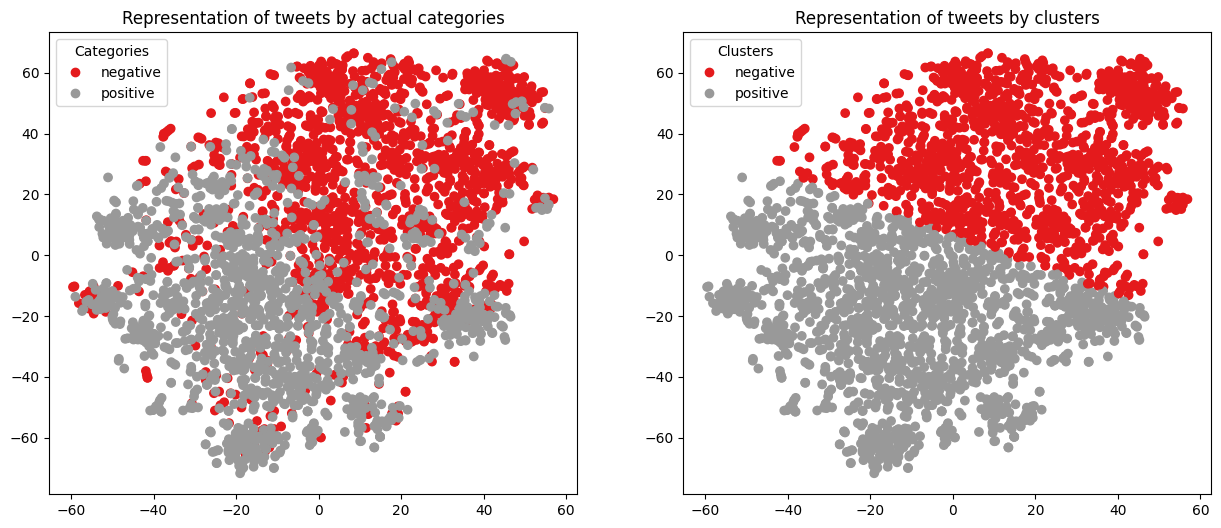

ARI :  0.352623709601874


In [55]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, wve_X_tsne, wve_clu_labels, wve_ari)

# BERT

ARI : 0.5

In [62]:
from tx_ml import load, encode_cats
tweets = load('3k_sample_clean.csv')
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
sents = tweets.sent_deep_learn

In [63]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:", n_gpu)
print("Built with cuda:", tf.test.is_built_with_cuda())

Tensorflow version: 2.11.0
Num GPUs Available: 0
Built with cuda: False


## BERT HuggingFace

### 'bert-base-uncased'

In [64]:
from transformers import TFAutoModel
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [65]:
# Création des features
from tx_ml import extract_bert_sentence_embeddings
bert_features, _ = extract_bert_sentence_embeddings(
    model,
    model_type,
    sents, 
    max_length,
    batch_size,
    mode='HF'
)

300/300 [==============================] - 232s 753ms/step


In [66]:
from tx_ml import tsne_kmeans_ari
bert_X_tsne, bert_clu_labels, bert_ari = tsne_kmeans_ari(bert_features, cat_codes, cat_labels)

T-SNE time: 31.55s
KMeans time: 0.19s
ARI time: 0.00s
Total time : 31.74s

ARI : 0.4805


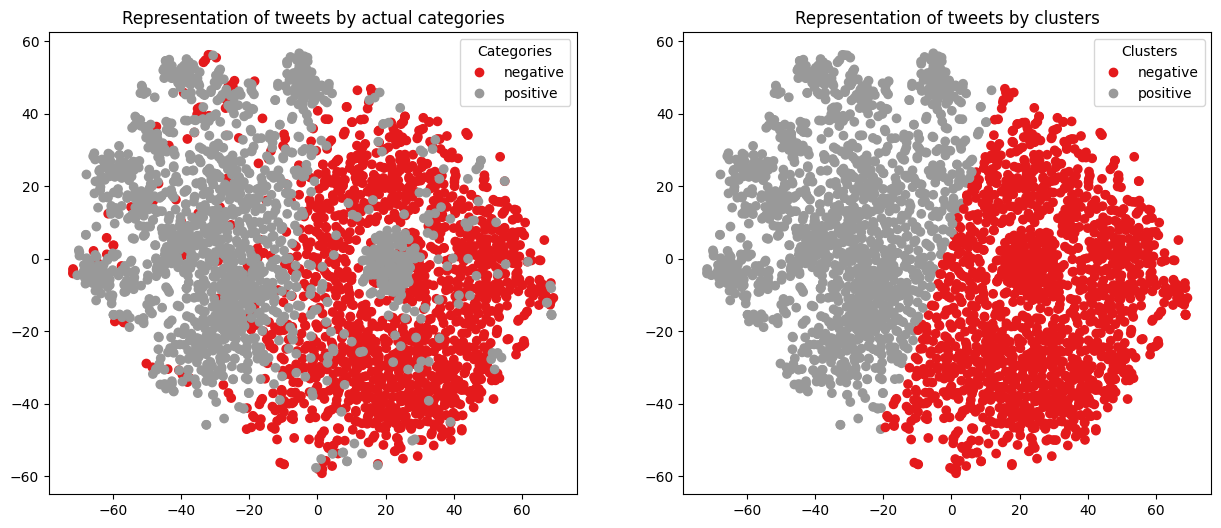

ARI :  0.4805384956948913


In [67]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, bert_X_tsne, bert_clu_labels, bert_ari)

# USE - Universal Sentence Encoder

ARI : 0.6

In [68]:
from tx_ml import load, encode_cats
from pepper_utils import show_discrete_stats

tweets = load('3k_sample_clean.csv')
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
sents = tweets.sent_deep_learn

In [69]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:", n_gpu)
print("Built with cuda:", tf.test.is_built_with_cuda())

Tensorflow version: 2.11.0
Num GPUs Available: 0
Built with cuda: False


In [70]:
# Création des features
from tx_ml import extract_use_sentence_embeddings
use_features = extract_use_sentence_embeddings(sents)

USE time: 2.14s


In [71]:
from tx_ml import tsne_kmeans_ari
use_X_tsne, use_clu_labels, use_ari = tsne_kmeans_ari(use_features, cat_codes, cat_labels)

T-SNE time: 55.04s
KMeans time: 0.55s
ARI time: 0.01s
Total time : 55.6s

ARI : 0.5211


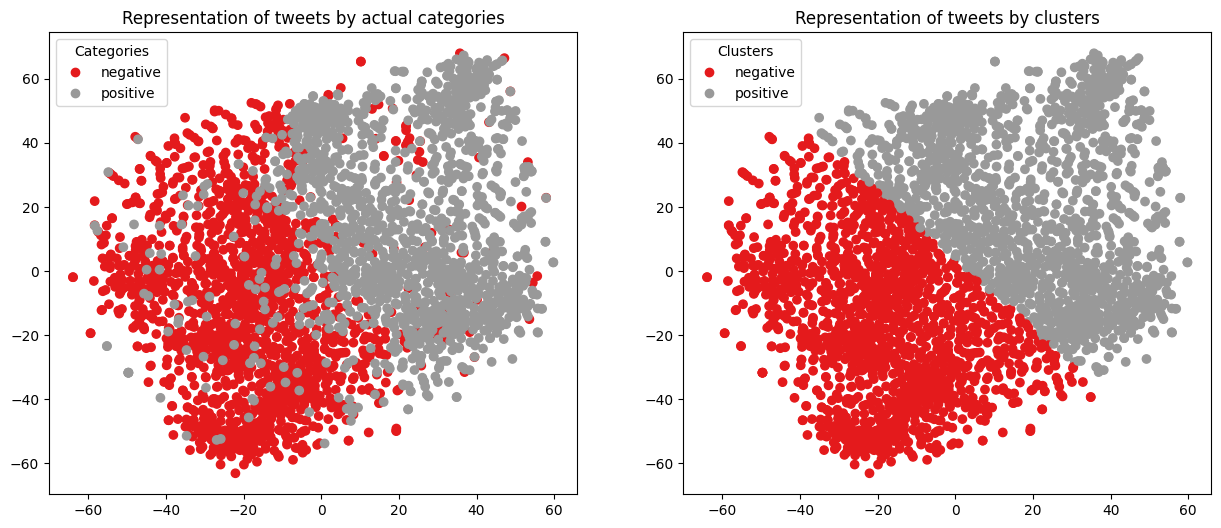

ARI :  0.5211243233224953


In [72]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, use_X_tsne, use_clu_labels, use_ari)